In [1]:
import numpy as np
import os
import pandas as pd
import run_openpose
import re
import cv2
import matplotlib.pyplot as plt

In [2]:
!ls
img_show_flag = False

Photos                    depth_test_notebook.ipynb run_openpose.py
README.md                 openpose_depth_test.py
__pycache__               pose


In [3]:
colors = [ [0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
         [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
         [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0], [0,0,0]]

In [4]:
directory = os.path.join('.','photos')
filename = os.path.join(directory,'annotations.json')

In [5]:
data=pd.read_json(filename)

In [6]:
data = data.transpose().reset_index()[['filename','regions','size']]

In [7]:
protoFile = os.path.join('.','pose','coco','pose_deploy_linevec.prototxt')
weightsFile = os.path.join('.','pose','coco','pose_iter_440000.caffemodel')

In [8]:
dist_data=[]
est_data=[]

In [9]:
for filename in os.listdir(directory):
    if filename.endswith('.jpg'):
        dist = {'Filename': filename, 'Distance': int(re.search('%s(.*)%s' % ('_', 'm'), filename).group(1))}
        print(os.path.join(directory, filename))
        estimate = run_openpose.run_openpose(os.path.join(directory, filename),protoFile,weightsFile)
        f=data['filename']==filename
        d=data['regions'][[i for i, x in enumerate(f) if x][0]]
        min_y = 10000000000000
        max_y = -1
        e = {'Filename': filename, 'Distance': int(re.search('%s(.*)%s' % ('_', 'm'), filename).group(1))}
        for e_point in estimate:
            if e_point:
                idx = e_point[0][3]
                e[idx] = (e_point[0][0],e_point[0][1])
                if (idx > 0) & (idx < 14):
                    if d[idx]['shape_attributes']:
                        x = d[idx]['shape_attributes']['cx']
                        y = d[idx]['shape_attributes']['cy']
                        min_y = min([y, min_y])
                        max_y = max([y, max_y])
                        dist[idx] = np.sqrt((e[idx][0]-x)**2+(e[idx][1]-y)**2)
        dist['Person Height'] = abs(max_y-min_y)
        if img_show_flag:
            frameClone = cv2.imread(os.path.join(directory, filename))
            for e_point in estimate[1:14]:
                cv2.circle(frameClone, tuple(e_point[0][0:2]), 5, colors[e_point[0][3]], -1)
                aux = d[e_point[0][3]]['shape_attributes']
                cv2.circle(frameClone, (aux['cx'], aux['cy']), 5, colors[e_point[0][3]//10], -1)
            cv2.imshow("Keypoints",frameClone)
            cv2.waitKey(0)

        dist_data.append(dist)
        est_data.append(e)

./photos/D_3m_2.jpg
./photos/D_3m_1.jpg
./photos/M_4m_2.jpg
./photos/D_7m_2.jpg
./photos/M_4m_1.jpg
./photos/D_15m_1.jpg
./photos/D_7m_1.jpg
./photos/M_3m_1.jpg
./photos/D_4m_4.jpg
./photos/D_4m_5.jpg
./photos/D_4m_6.jpg
./photos/D_4m_2.jpg
./photos/M_15m_1.jpg
./photos/M_7m_2.jpg
./photos/D_4m_3.jpg
./photos/D_4m_1.jpg
./photos/M_15m_2.jpg
./photos/M_7m_1.jpg


In [16]:
est = pd.DataFrame(est_data)
est[['Filename','Distance',1,2,3,4,5,6,7,8,9,10,11,12,13]].sort_values(by=['Distance'])

,Filename,Distance,1,2,3,4,5,6,7,8,9,10,11,12,13
0,D_3m_2.jpg,3,"(2226, 1271)","(2097, 1270)","(2031, 1467)","(1966, 1662)","(2417, 1271)","(2420, 1467)","(2484, 1663)","(2160, 1597)","(2096, 1727)","(2161, 2054)","(2290, 1662)","(2226, 1989)","(2162, 2315)"
1,D_3m_1.jpg,3,"(1967, 1336)","(1838, 1337)","(1774, 1596)","(1774, 1793)","(2097, 1336)","(2354, 1272)","(2548, 1271)","(1902, 1793)","(1839, 2054)","(1838, 2379)","(2033, 1793)","(2033, 2054)","(2032, 2380)"
7,M_3m_1.jpg,3,"(2031, 1271)","(1839, 1271)","(1774, 1467)","(1710, 1728)","(2161, 1271)","(2225, 1531)","(2161, 1467)","(1902, 1727)","(1902, 2054)","(1902, 2444)","(2096, 1727)","(2096, 2055)","(2095, 2445)"
15,D_4m_1.jpg,4,"(2031, 1596)","(1903, 1596)","(1839, 1727)","(1774, 1857)","(2097, 1596)","(2161, 1727)","(2227, 1857)","(1967, 1922)","(1967, 2119)","(1967, 2315)","(2096, 1922)","(2096, 2119)","(2096, 2315)"
14,D_4m_3.jpg,4,"(2096, 1532)","(2031, 1532)","(1967, 1401)","(1967, 1271)","(2161, 1532)","(2225, 1402)","(2225, 1271)","(2032, 1858)","(2032, 2055)","(2032, 2251)","(2161, 1858)","(2161, 2054)","(2161, 2313)"
11,D_4m_2.jpg,4,"(2095, 1597)","(1967, 1597)","(1839, 1727)","(1710, 1793)","(2161, 1597)","(2226, 1664)","(2356, 1793)","(2031, 1923)","(2031, 2119)","(2031, 2316)","(2160, 1923)","(2161, 2119)","(2161, 2315)"
10,D_4m_6.jpg,4,"(2032, 1663)","(1904, 1663)","(1774, 1726)","(1774, 1533)","(2161, 1663)","(2290, 1727)","(2290, 1596)","(1967, 2053)","(1967, 2250)","(1968, 2509)","(2097, 2053)","(2097, 2250)","(2160, 2510)"
9,D_4m_5.jpg,4,NaN,"(2096, 1728)",NaN,"(3257, 1728)",NaN,"(1903, 1859)",NaN,"(1839, 1990)",NaN,"(2161, 1728)",NaN,"(2225, 1858)",NaN
8,D_4m_4.jpg,4,"(2031, 1206)","(1903, 1206)","(1774, 1206)","(1645, 1142)","(2097, 1206)","(2288, 1206)","(2418, 1206)","(1967, 1532)","(1967, 1728)","(1967, 1924)","(2096, 1532)","(2096, 1728)","(2096, 1924)"
4,M_4m_1.jpg,4,"(1709, 1402)","(1644, 1402)","(1515, 1532)","(1580, 1402)","(1838, 1403)","(1839, 1533)","(1903, 1727)","(1645, 1728)","(1645, 1925)","(1645, 2184)","(1774, 1728)","(1774, 1987)","(1774, 2185)"


In [11]:
dist_dataframe = pd.DataFrame(dist_data) 
dist_dataframe.sort_values(by=['Distance'])

,Filename,Distance,1,2,3,4,5,6,7,8,9,10,11,12,13,Person Height
0,D_3m_2.jpg,3,78.873316,71.840100,15.620499,6.708204,30.675723,65.299311,47.853944,23.769729,58.000000,48.166378,42.047592,67.955868,58.240879,1078
1,D_3m_1.jpg,3,34.828150,18.110770,42.544095,50.219518,67.675697,42.047592,37.215588,17.804494,54.378304,54.451814,46.043458,79.981248,58.180753,1062
7,M_3m_1.jpg,3,35.383612,46.529560,54.203321,56.435804,51.244512,43.566042,68.249542,38.183766,34.785054,64.938432,40.804412,52.924474,20.615528,1180
15,D_4m_1.jpg,4,44.944410,59.539903,51.894123,21.213203,57.384667,46.818800,56.462377,23.600847,7.071068,26.925824,13.416408,28.231188,26.683328,767
14,D_4m_3.jpg,4,19.235384,13.928388,10.440307,27.018512,45.694639,33.837849,12.206556,59.413803,31.827661,31.240999,50.695167,44.687806,44.553339,1011
11,D_4m_2.jpg,4,15.132746,39.357337,66.370174,48.662100,35.846897,57.775427,50.000000,4.000000,13.038405,18.027756,7.810250,23.086793,28.600699,759
10,D_4m_6.jpg,4,37.107951,48.846699,35.383612,19.723083,28.425341,56.080300,48.600412,27.018512,36.878178,61.400326,41.000000,72.615425,40.199502,929
9,D_4m_5.jpg,4,NaN,96.628153,NaN,1388.703352,NaN,341.177373,NaN,221.677694,NaN,769.615488,NaN,435.900218,NaN,773
8,D_4m_4.jpg,4,16.401219,48.041649,30.083218,47.801674,50.219518,15.033296,10.295630,26.925824,9.486833,17.262677,10.770330,12.806248,11.180340,749
4,M_4m_1.jpg,4,55.470713,21.540659,41.400483,23.769729,30.805844,66.850580,31.240999,50.119856,62.425956,48.795492,47.381431,45.541190,51.000000,767


In [12]:
aux=np.array(dist_dataframe['Distance'])

In [13]:
distances = np.unique(aux)
mean_dist = 100000*np.ones(distances.shape)

for j,i in enumerate(distances):
    temp = np.array(dist_dataframe[dist_dataframe.columns[2:]][dist_dataframe['Distance']==i].div(dist_dataframe[dist_dataframe.columns[-1]][dist_dataframe['Distance']==i]))
    mean_dist[j] = np.nanmean(temp)
    
#old
#distances = np.unique(aux)
#mean_dist = 100000*np.ones(distances.shape)

#for j,i in enumerate(distances):
#    temp = np.array(dist_dataframe[dist_dataframe.columns[2:]][dist_dataframe['Distance']==i])
#    mean_dist[j] = np.nanmean(temp)
    
  

In [14]:
dist_dataframe[dist_dataframe.columns[2:]][dist_dataframe['Distance']==i]

,1,2,3,4,5,6,7,8,9,10,11,12,13,Person Height
5,56.885851,24.083189,76.550637,106.066017,24.515301,28.861739,52.497619,39.824616,32.649655,169.292646,23.409400,246.028454,306.104557,242
12,6.324555,37.000000,48.093659,126.063476,31.048349,53.366656,84.646323,35.383612,91.181138,174.951422,26.925824,82.225300,236.611496,237
16,NaN,8.544004,31.622777,118.680243,68.963759,76.655072,105.546198,47.296934,11.401754,114.109596,90.917545,89.308454,255.765518,299


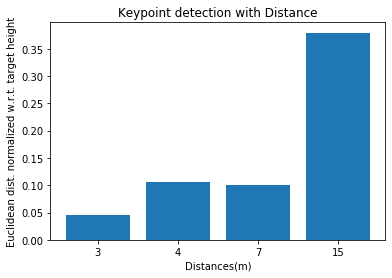

[0.04505214 0.10580115 0.09957878 0.37940699]


In [15]:
%matplotlib inline

index = np.arange(len(distances))
plt.bar(index, mean_dist)
plt.xlabel('Distances(m)', fontsize=10)
plt.ylabel('Euclidean dist. normalized w.r.t. target height', fontsize=10)
plt.xticks(index, distances, fontsize=10, rotation=0)
plt.title('Keypoint detection with Distance')
plt.show()

print(mean_dist)